In [1]:
import matplotlib.pyplot as plt
import torch

from src import read_dicom, Detector, Siddon

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Read in the volume
volume, spacing = read_dicom("../data/cxr/")
volume[volume < 0] = 0
isocenter = [0., 0., 0.]
siddon = Siddon(spacing, isocenter, volume, device)

# Send rays through the center of the volume
torch.tensor(volume.shape) * torch.tensor(spacing) / 2

tensor([180.0000, 180.0000, 166.2500], dtype=torch.float64)

In [3]:
# Make the detector plane
detector = Detector(
    sdr    =  300.,
    theta  =  torch.pi,
    phi    =  0,
    gamma  =  torch.pi / 2,
    bx     =  180.,
    by     =  180.,
    bz     =  166.25,
    device =  device,
)

angles = detector.angles
source, rays = detector.make_xrays(600, 600, 1.5, 1.5)

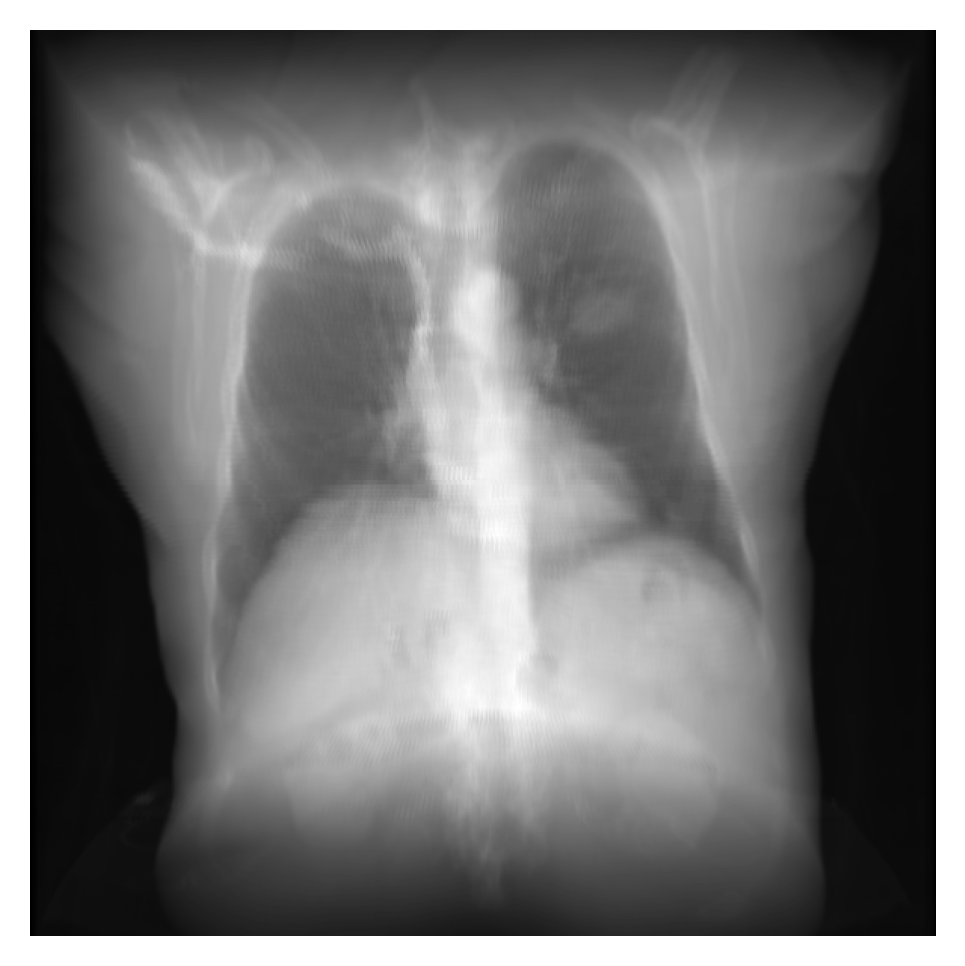

In [4]:
# Make the DRR
drr = siddon.raytrace(source, rays)

fig, ax = plt.subplots(dpi=300)
ax.imshow(drr.detach().cpu(), cmap="gray")
ax.axis("off")
plt.savefig("../figures/example_DRR.pdf")
plt.show()